# Practical Activity 1 (**PRA1**)

## Evaluable Practical Exercise

<u>General considerations</u>:
 The proposed solution cannot use methods, functions or parameters declared **_deprecated_** in future versions.
-
- This activity must be carried out on a **strictly individual** basis. Any indication of copying will be penalized with a failure for all parties involved and the possible negative evaluation of the subject in its entirety.
- It is necessary for the student to indicate **all the sources** that she/he has used to carry out the PRA. If not, the student will be considered to have committed plagiarism, being penalized with a failure and the possible negative evaluation of the subject in its entirety.

<u>Delivery format</u>:

- Some exercises may require several minutes of execution, so the delivery must be done in **Notebook format** and in **HTML format**, where the code, results and comments of each exercise can be seen. You can export the notebook to HTML from the menu File $\to$ Download as $\to$ HTML.
- There is a special type of cell to hold text. This type of cell will be very useful to answer the different theoretical questions posed throughout the activity. To change the cell type to this type, in the menu: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Name and surname:</strong> Pere Mayol Carbonell
</div>

## Introduction

Blackjack environment is part of the Gymnasium's [Toy Text](https://gymnasium.farama.org/environments/toy_text/) environments. Blackjack is a card game where the goal is to beat the dealer by obtaining cards that sum to closer to 21 (without going over 21) than the dealer's cards.

The game starts with the dealer having one face up and one face down card, while the player has two face up cards. All cards are drawn from an infinite deck (i.e. with replacement).

The card values are, as depicted in the following figure:
- Face cards (Jack, Queen, King) have a point value of **10**.
- Aces can either count as **11** (called a ``usable ace'') or **1**.
- Numerical cards (**2-9**) have a value equal to their number.

<img src="./figs/BlackJackCards.png" />

The player has the sum of cards held. The player can request additional cards (**hit**) until they decide to stop (**stick**) or exceed 21 (**bust**, immediate loss).

After the player sticks, the dealer reveals their face down card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins.

If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.

Further information could be found at:
- Gymnasium [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/)

In order to initialize the environment, we will use `natural=True` to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21), as depicted in the following piece of code:

In [108]:
!pip install gymnasium
!pip install tensorboardX

#import necessary labraries to run the notebook.
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
from tensorboardX import SummaryWriter


env = gym.make('Blackjack-v1', natural=True, sab=False)

In [109]:
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))
#print("Reward range is {} ".format(env.reward_range))

Action space is Discrete(2) 
Observation space is Tuple(Discrete(32), Discrete(11), Discrete(2)) 


FOR THE INITIAL BASIS OF THESE ALGORITHMS, SOME IDEAS FROM THE CLASS EXAMPLES WHERE USED, ALONG WITH HELP FROM THE STRUCTURE OF OTHER SOURCES:

*   Examples from class for MC and SARSA.
*   https://www.kaggle.com/code/angps95 blackjack-strategy-using-reinforcement-learning

THESE WERE USED SIMPLY ORIENTATIVELY AND TO SET A BASIS OF THE IDEA BEHIND THESE ALGORITHMS. SOME PARTS OF THE plot_policy function, (INVOLVED IN THE CREATION OF THE GUIDE AND AESTHETICS OF THE PLOTS) WHERE DONE WITH SOME INSIGHT FROM chatgpt.


## Part 1. Naïve Policy

Implement an agent that carries out the following deterministic policy:
- The agent will **stick** if it gets a score of 20 or 21.
- Otherwise, it will **hit**.

<u>Questions</u> (**1 point**):
1. Using this agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
2. Additionally, calculate the % of wins, natural wins, losses and draws.
3. Comment on the results: The results make sense, since the policy is extremely simple as it just acts based on the binary possibility of being over/equal or under 20. So if we just hit or stick based on this, it makes sense that we lose most of the times and, due to way the game works, we are lucky enough to get a winning hand just a few episodes.

In [125]:
#define the function for the naive policy:
def naive_policy(player_score):
    if player_score >= 20:
        return 0  #if player_score is over twenty, stick
    else:
        return 1  #if its under, hit

def naive(env, num_games= 100000):
    #initialize parameters to keep track of results.
    wins = 0
    losses = 0
    draws = 0
    natural_wins = 0
    total_reward = 0

    #run for the num_games that we want.
    for _ in range(num_games):
        #create initial situation.
        #reset environment, create boolean for main loop.
        observation, _ = env.reset()
        done = False
        initial_player_score = observation[0]
        if initial_player_score == 21:
          is_natural = True
          natural_wins += 1
        else:
          is_natural = False #check if the win was natural, update the boolean value.

        #iterate until the environment is done.
        while not done:
            action = naive_policy(observation[0])
            observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        total_reward += reward #update the total reward

        #update all parameters based on results.
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    #create dictionary to stroe all rsults and print them more easily after.
    results_naive = {'WIN PERCENTATGE:': (wins / num_games) * 100, 'NATURAL WINS PERCENTATGE:':  (natural_wins / num_games) * 100, 'LOSSES PERCENTATGE:': (losses / num_games) * 100, 'DRAWS:': (draws / num_games) * 100, 'TOTAL RETURN:': total_reward}
    return results_naive

res_naive = naive(env, 100000)
for k,i in res_naive.items():
    print(k)
    print("%.2f" % i)


WIN PERCENTATGE:
24.97
NATURAL WINS PERCENTATGE:
4.78
LOSSES PERCENTATGE:
64.97
DRAWS:
10.06
TOTAL RETURN:
-33628.50


Part 2. Monte Carlo method

The objective of this section is to estimate the optimal policy using Monte Carlo methods. Specifically, you can choose and implement one of the algorithms related to _Control using MC methods_ (with ''exploring starts'' or without ''exploring starts'', both on-policy or off-policy).

# <u>Questions</u> (**2.5 points**):
##1. Implement the selected algorithm and justify your choice.
The algorithm I have selected is On-policy first-visit using epsilon greedy exploration. I have chosen this algorithm because:

*   **First-visit:** this is because this type of algorithm reduces variance in updates, which is actually beneficial in stohastic situations such as BlackJack, where same state-action pairs can produce different rewards within the same episode. So, we only update Q based on the first time we visit a state-action pair.

*   **On-policy:** this choice is based on the idea that it allows the agent to directly improve the same policy it uses to interact with the environment. It is also less complex than off-policy, it naturally incorporates exploration thorugh epsilon-greedy action selection. (no importance sampling also). So its better and easier to learn an optimal policy in this case.

*   **No Exploring starts:** Many states are naturally unreachable so it does not make much sense to do exploring starts. It adds unnecessary complexity and introduces initial states that are impossible even. Learning fro realistic and practical episodes makes a lot more sense.


## 2. Comment and justify all the parameters, such as: (num_episodes=200000, gamma=0.1, epsilon=1.0, epsilon_decay = 0.99)
- Number of episodes, in this case 200.000 due to the fact that a large amount of episodes allows the agent to explore a large amount of state-action pairs, which there are a lot of in Blackjack.
- Discount factor [0.1] , focus on rewards more immediately, suitable for episodic tendencies like in games like blackjack where decisons have high short term impact.
- Epsilon [1.0] and epsilon decay [0.99] , makes sense since: a high epsilon make sure the agent does not rely on initial unreliable vaues of Q, and the decaying value allows for a smooth transition to exploiting learned actions.

3. Implement a function that prints on the screen the optimal policy found for each state (similar to the figure in Section 3.1).
4. Using the trained agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
5. Additionally, calculate the % of wins, natural wins, losses and draws.

# **I HAVE GOTTEN TO THESE VALUES THROUGH LOGIC, BUT MOSTLY TESTING TO PROVE IT VIA TRIAL AND ERROR FOR THE DIFFERENT PARAMETERS AND ITS VALUES.**

In [111]:
writer = SummaryWriter(comment="-mc_control")

#function to generate the policy function and the array containing the probabilities for each action.
def make_epsilon_policy(Q, epsilon, num_actions):

    def policy_mc(observation):
        A = np.ones(num_actions, dtype = float) * epsilon / num_actions
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0-epsilon)
        return A
    return policy_mc


def mc_control_onpolicy_epsilon_greedy(env, num_episodes, gamma=0.1, epsilon=1.0, epsilon_decay = 0.99):


    #Q action value function, nested dictionary to store all returns.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    #we store the sum and number of returns for each state to calculate the average.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)


    y = np.zeros(num_episodes, dtype=np.float16) #rewards

    for i_episode in range(num_episodes):
        policy = make_epsilon_policy(Q, epsilon, env.action_space.n)

        #update epsilon
        epsilon = max(epsilon * epsilon_decay, 0.09)

        #generate initial variables needed and reset environment.
        episode = []
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            #use policy to determine the next action
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)

            #use action to generate next state, check if done and update needed variables.
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            total_reward += reward

            state = next_state

        #add total_reward to the rewards array and initialise G value.
        y[i_episode] = total_reward
        G = 0

        #generate list for first-visit
        visited_pairs = set()

        #iterate through generated episodes in reverse.
        for state, action, reward in reversed(episode):
            #select each state-pair action in the generated episodes apply the known formula for this algorithm.
            sa_pair = (state,action)
            if sa_pair not in visited_pairs:
                visited_pairs.add(sa_pair)
                G = gamma * G + reward

                returns_sum[sa_pair] += G
                returns_count[sa_pair] += 1.0
                Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]


        # write to summary
        writer.add_scalar("reward", total_reward, i_episode)

        #print the episode and the total average
        if i_episode % 100 == 0 and i_episode > 0:
            print("\rEpisode {:8d}/{:8d} - Average reward {:.2f}".format(i_episode, num_episodes, np.average(y[:i_episode])), end="")
            sys.stdout.flush()

    #return the policy and Q to simulate the rest of the games and get the optimal policy given by the function.
    return policy, Q

#function to simulate games based on the policy found in the first part and get results.
def simulate_games_mc(env, policy, num_simulations=100000):
    #initialise variables to store results.
    total_reward = 0
    wins, losses, draws, natural_wins = 0, 0, 0, 0

    #iterate for the number of simulations wanted.
    for _ in range(num_simulations):
        #reset environment and create needed variables.
        state, _ = env.reset()
        done = False #to check if its truncated or terminated at each new state.
        initial_player_score = state[0]
        if initial_player_score == 21:
          natural_wins += 1
          #check if the win was natural, update natural wins results value.

        while not done:
            #at each time step choose action based on known policy and generate new step.
            action = np.argmax(policy(state)) #choose action
            state, reward, terminated, truncated, _ = env.step(action) #based on action generate next step.
            done = terminated or truncated #check if loop should be ended.
            total_reward += reward #upload the reward.

        #update result variables depending on the final reward.
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    #dictionary to store all results and print them afterwards.
    results_total = {'WINS': (wins/num_simulations)*100, 'NATURAL WINS': (natural_wins/num_simulations)*100, 'LOSSES': (losses/num_simulations)*100, 'DRAWS': (draws/num_simulations)*100, 'TOTAL REWARD': total_reward}

    return results_total


num_episodes = 200000 #desired number of episodes to generate the policy.
policy_mc, Q_mc = mc_control_onpolicy_epsilon_greedy(env, num_episodes) #call function to generate the policy and Q.
total_results_mc = simulate_games_mc(env, policy_mc) #simulate for n episodes and check results.

#print results for all interesting variables.
print('\n--------------------------------------------------------------')
for key, value in total_results_mc.items():
  print(key)
  print("%.2f" % value)

Episode    65700/  200000 - Average reward -0.08

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


Episode   199900/  200000 - Average reward -0.07
--------------------------------------------------------------
WINS
38.70
NATURAL WINS
4.65
LOSSES
48.17
DRAWS
13.13
TOTAL REWARD
-3331.00


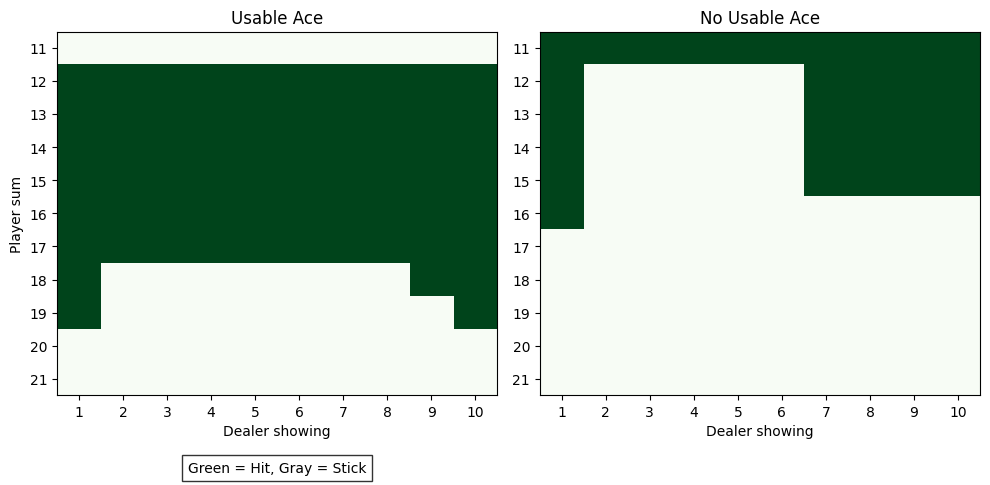

In [112]:
#function to print the different policies, create a matrix with different possible states and populate them based on the given Q.
def plot_policy(Q):
    #define possible player sums and dealer showing values
    player_sums = range(11, 22)  # player sums from 11 to 21
    dealer_showing = range(1, 11)  # dealer's face-up card from 1 to 10

    #initialize simple policy matrices for states with and without a usable ace
    policy_with_usable_ace = np.zeros((len(player_sums), len(dealer_showing))) #create them based on the lenght of the variables created before, based on the image described by Sutton & Barto
    policy_without_usable_ace = np.zeros((len(player_sums), len(dealer_showing)))

    #populate policy matrices
    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_showing):
            #set up states for usable and non-usable ace scenarios
            state_with_ace = (player_sum, dealer_card, True)
            state_without_ace = (player_sum, dealer_card, False)

            #check if states exist in Q, then set action (0=Stick, 1=Hit)
            if state_with_ace in Q:
                policy_with_usable_ace[i, j] = np.argmax(Q[state_with_ace])
            if state_without_ace in Q:
                policy_without_usable_ace[i, j] = np.argmax(Q[state_without_ace])

    #plot policies in a basic format
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    #plot policy with a usable ace
    ax1.imshow(policy_with_usable_ace, cmap="Greens", aspect="auto")
    ax1.set_title("Usable Ace")
    ax1.set_xticks(range(len(dealer_showing)))
    ax1.set_xticklabels(dealer_showing)
    ax1.set_yticks(range(len(player_sums)))
    ax1.set_yticklabels(player_sums)
    ax1.set_xlabel("Dealer showing")
    ax1.set_ylabel("Player sum")

    #add color labels directly to the plot
    ax1.text(0.5, -0.2, "Green = Hit, Gray = Stick", transform=ax1.transAxes,
             ha="center", va="center", fontsize=10, color="black", bbox=dict(facecolor="white", alpha=0.8))

    #plot policy without a usable ace
    ax2.imshow(policy_without_usable_ace, cmap="Greens", aspect="auto")
    ax2.set_title("No Usable Ace")
    ax2.set_xticks(range(len(dealer_showing)))
    ax2.set_xticklabels(dealer_showing)
    ax2.set_yticks(range(len(player_sums)))
    ax2.set_yticklabels(player_sums)
    ax2.set_xlabel("Dealer showing")


    plt.tight_layout()
    plt.show()

#using the function to print the plot of the policy based on Q.
plot_policy(Q_mc)



## Part 3. TD learning

The objective of this section is to estimate the optimal policy using TD learning methods. Specifically, you have to implement the SARSA algorithm.

<u>Questions</u> (**2.5 points**):
1. Implement the algorithm.
2. Comment and justify all the parameters.
- Number of episodes, in this case 250.000 due to the fact that a large amount of episodes allows the agent to explore a large amount of state-action pairs, which there are a lot of in Blackjack.
-Learning Rate[0.05], a low value allows the algorithm to make incremental updates without overwhelming previously learned information. This rate is well-suited to a stochastic environment like Blackjack.
- Discount factor [0.1] , focus on rewards more immediately, suitable for episodic tendencies like in games like blackjack where decisons have high short term impact.
- Epsilon [1.0] and epsilon decay [0.99] , makes sense since: a high epsilon make sure the agent does not rely on initial unreliable vaues of Q, and the decaying value allows for a smooth transition to exploiting learned actions.
best-known actions as training progresses.

3. Implement a function that prints on the screen the optimal policy found for each state (similar to the figure in Section 3.1).
4. Using the trained agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
5. Additionally, calculate the % of wins, natural wins, losses and draws.
3. Print on the screen the optimal policy found for each state.
4. Using the trained agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
5. Additionally, calculate the % of wins, natural wins, losses and draws.


# **I HAVE GOTTEN TO THESE VALUES THROUGH LOGIC, BUT MOSTLY TESTING IT VIA TRIAL AND ERROR FOR THE DIFFERENT PARAMETERS AND ITS VALUES.**

In [113]:
def sarsa_policy(env, Q, epsilon):
    '''
    Create a policy where epsilon dictates the probability of a random action being carried out.

    :param Q: link state -> action value (dictionary)
    :param state: state in which the agent is (int)
    :param nA: number of actions (int)
    :param epsilon: possibility of random movement (float)
    :return: probability of each action (list) d
    '''
    def policy(state):
        probs = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[state])
        probs[best_action] += (1.0 - epsilon)
        return probs

    return policy

#function for SARSA algorithm
def SARSA(env, episodes:int, learning_rate:float, discount:float, epsilon:float, epsilon_decay:float):
    #initialise variables to store results
    wins = 0
    losses = 0
    draws = 0
    natural_wins = 0
    total_reward = 0

    #initialise Q value and array to store rewards
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    y = np.zeros(episodes)

    for episode in range(episodes):
        #decay epsilon and load the policy function based on that value
        epsilon = max(epsilon * epsilon_decay, 0.0)
        policy = sarsa_policy(env, Q, epsilon)

        #reset environment and iniciate new state. Create variable to che
        state, _ = env.reset()
        initial_player_score = state[0]
        is_natural = initial_player_score == 21
        done = False

        #initialise an action based on the policy.
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)

        total_reward = 0 #variable to know the total reward.
        while not done:
            #generate new state and reward. Check if its terminated or truncated.
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            #Update total reward, the probs and the next action to be taken.
            total_reward += reward
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)

            if done:
                td_target = reward
            else:
                td_target = reward + discount * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += learning_rate * td_error

            #transition to next states and actions.
            state = next_state
            action = next_action

        y[episode] = total_reward
        #write the reward
        writer.add_scalar("reward", total_reward, episode)

        #print depending on the episode number.
        if episode % 100 == 0 and episode > 0:
            print("\rEpisode {:8d}/{:8d} - Average reward {:.2f}".format(episode, episodes, np.average(y[:episode])), end="")
            sys.stdout.flush()

    return y, Q, policy


#function to simulate games based on the learnt policy.
def simulate_games_sarsa(env, policy, num_simulations=100000):
    total_reward = 0
    wins, losses, draws, natural_wins = 0, 0, 0, 0

    for _ in range(num_simulations):
        state, _ = env.reset()
        done = False
        initial_player_score = state[0]

        while not done:
            action = np.argmax(policy(state))
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        if reward == 1:
            wins += 1
            if initial_player_score==21:
                natural_wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    results_total = {'WINS': (wins/num_simulations)*100, 'NATURAL WINS': (natural_wins/num_simulations)*100, 'LOSSES': (losses/num_simulations)*100, 'DRAWS': (draws/num_simulations)*100, 'TOTAL REWARD': total_reward}

    return results_total


y, Q_sarsa, policy = SARSA(env, episodes=250000, learning_rate=0.05, discount=0.1, epsilon=1.0, epsilon_decay=0.99)
total_results_sarsa = simulate_games_sarsa(env, policy)


#print results for all interesting variables.
print('\n--------------------------------------------------------------')
for key, value in total_results_sarsa.items():
  print(key)
  print("%.2f" % value)


Episode   249900/  250000 - Average reward -0.04
--------------------------------------------------------------
WINS
38.10
NATURAL WINS
0.00
LOSSES
48.02
DRAWS
13.87
TOTAL REWARD
-3445.50


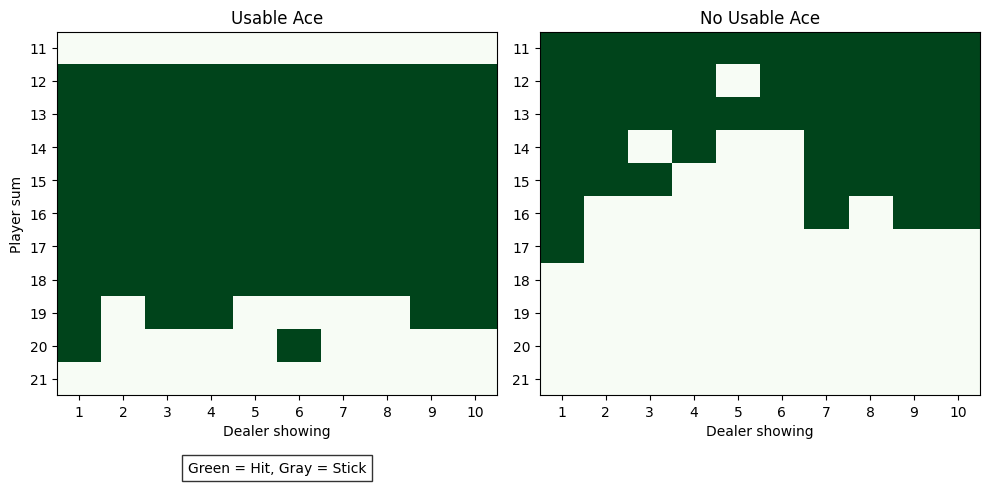

In [114]:
plot_policy(Q_sarsa)

## Part 4. Comparison of the algorithms

In this section, we will make a comparison among the algorithms.

We will compare the performance of the algorithms when changing the number of episodes, the discount factor and the *learning rate* values (in the case of the SARSA method).

For each exercise, the results must be presented and justified.

**Note**:
- It is recommended to run the simulations multiple times for each exercise, as these are random, and to comment on the most frequent result or the average of these.

### 4.1. Comparison to the optimal policy

The optimal policy for this problem, described by [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html) is depicted in the following image:

<img src="./figs/optimal.png" style="width: 800px;" />

<u>Questions</u> (**1 point**):
- Compare the _optimal_ policies of the naïve, Monte Carlo and SARSA methods to the optimal one provided by Sutton & Barto.
- Comment on the results and justify your answer.


-----------------------------------NAIVE POLICY--------------------------------------



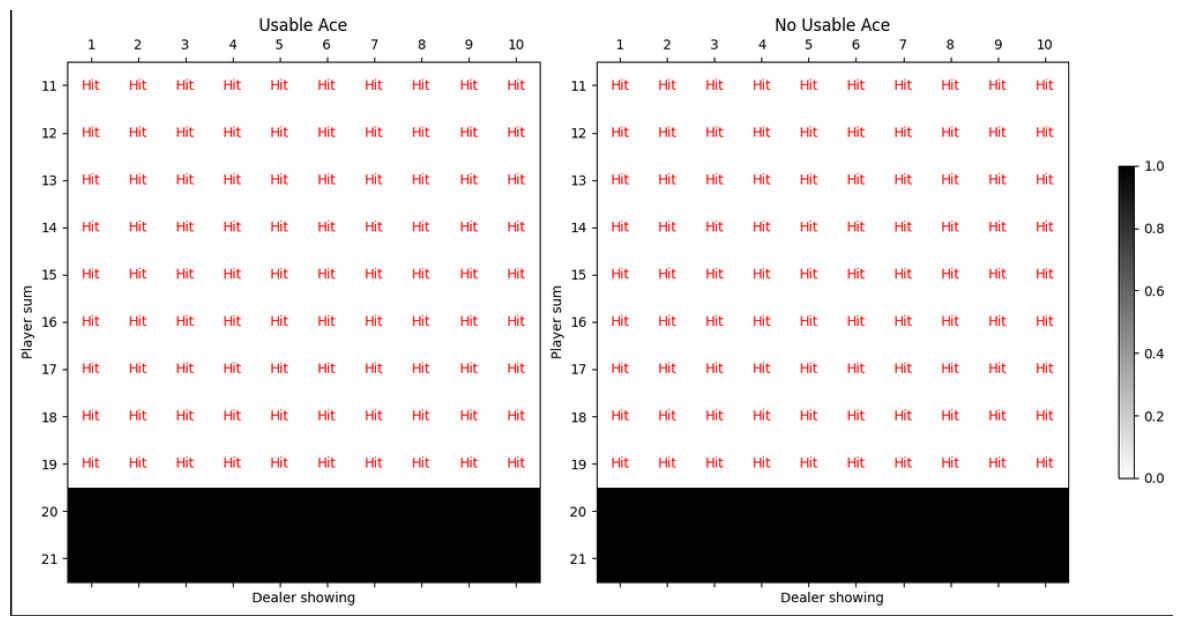


------------------------------------MONTE CARLO--------------------------------------



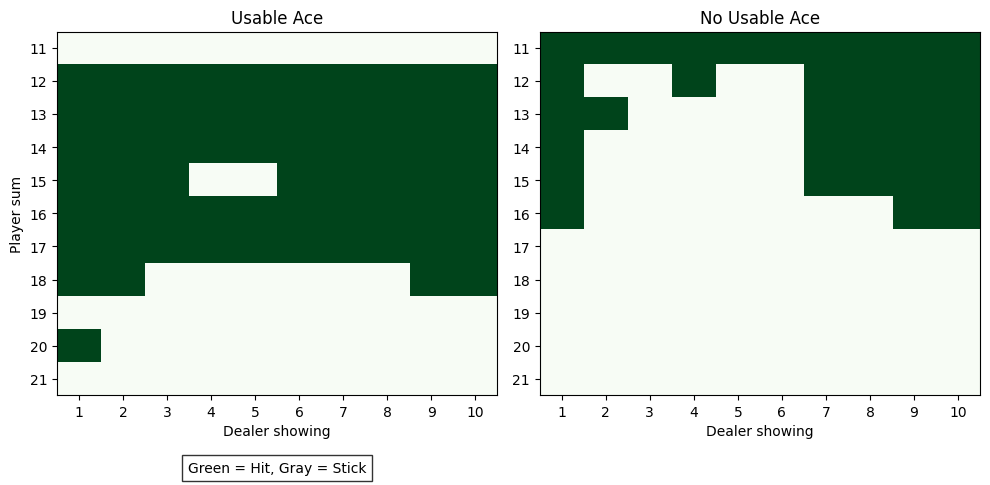


--------------------------------------SARSA------------------------------------------



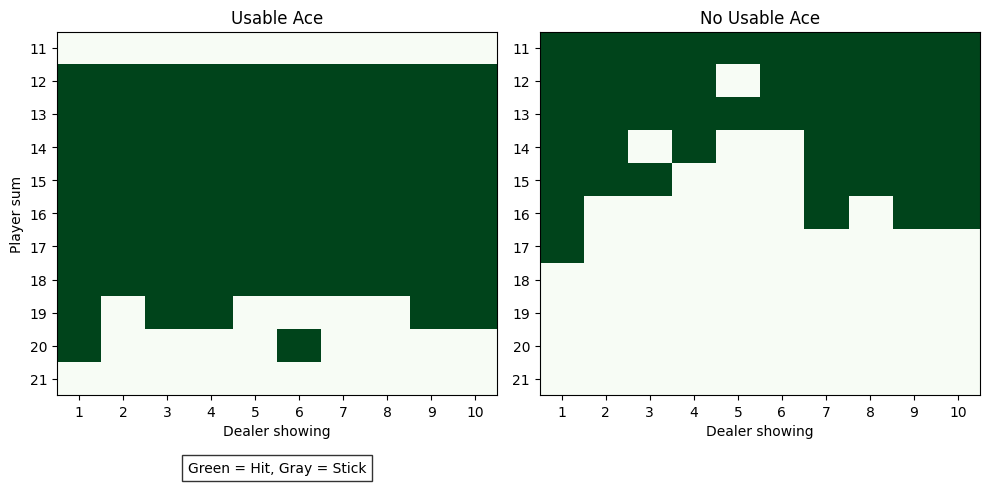

In [123]:
from PIL import Image


print('\n-----------------------------------NAIVE POLICY--------------------------------------\n')

image = Image.open('naive policy.png')

plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis('off')
plt.show()

print('\n------------------------------------MONTE CARLO--------------------------------------\n')
plot_policy(Q_mc)

print('\n--------------------------------------SARSA------------------------------------------\n')
plot_policy(Q_sarsa)


# **COMMENT ON OPTIMAL POLICIES OBTAINED THROUGH EACH ALGORITHM**
 Firstly, the **naive policy** is straight forward since the only thing that can make the agent take one action or the other is the number that itself is holding. So if its equal or larger than 20, its going to stick and if not it hits. Its very far away from the optimal policy.

Secondly, the policy obtained by the **Monte Carlo** algorithm, when the agent is not holding any usable aces, is very very similar to the optimal one. Nevertheless, when usable aces come into play, the policy is kind of far away from what we should expect, this may be to a problem in the code so the agent is not trained enough torwards usable aces. But we can clearly see that they are both very similar and that they very good results.

Finally, the **SARSA** algorithm gets close to the optimal policy in both but there are some problems that make them differ. We can also see that, simingly as with the Monte carlo, there is a problem with the policy with usable aces when the player's sum is equal to 11.

Even if there are some minor issues that make these policies be different from the optimal one, they are both pretty good (specially the monte carlo) and make a fair representation of the needed actions in order tp maximise the reward in the game of BlackJack.

### 4.2. Influence of the Number of Episodes

Conduct a study by varying the number of episodes in each of the algorithms.

<u>Questions</u> (**1 point**):
- Train each algorithm multiple times with 100,000, 1,000,000, and 5,000,000 episodes and average the results.
- Indicate how the **number of episodes** influences the convergence of each algorithm by calculating the number of states where the policy differs from the optimal one, as well as the average return obtained after playing 100,000 games following each training.

In [155]:
episodes =[100000, 1000000]

averages_sarsa = []

AV_S={}


SARSA
Episode    99900/  100000 - Average reward -0.05--------------------------------------------------------------

FOR SARSA WITH 100000 EPISODES 
RESULTS ARE: {'WINS': 38.054, 'NATURAL WINS': 0.0, 'LOSSES': 48.473, 'DRAWS': 13.472999999999999, 'TOTAL REWARD': -4287.0} 
AND POLICY IS:


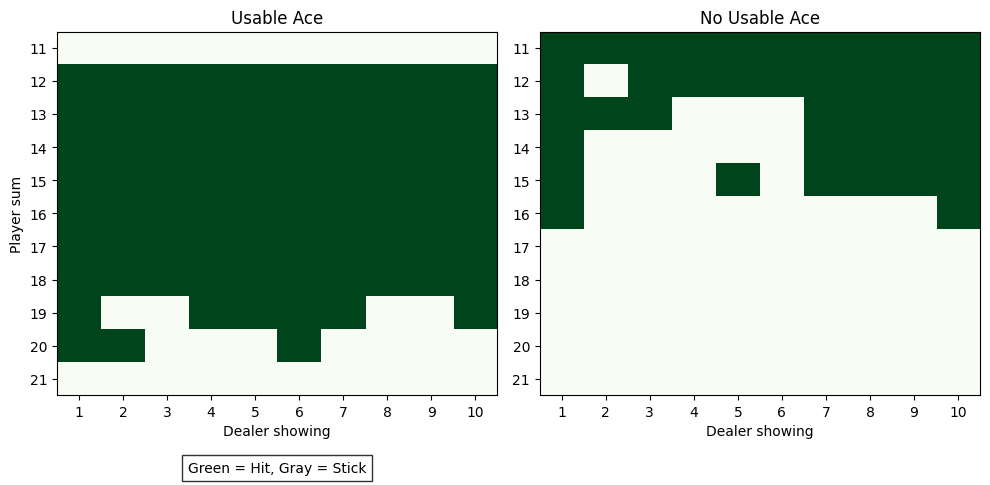

--------------------------------------------------------------

Episode   999900/ 1000000 - Average reward -0.04--------------------------------------------------------------

FOR SARSA WITH 1000000 EPISODES 
RESULTS ARE: {'WINS': 37.942, 'NATURAL WINS': 0.0, 'LOSSES': 48.347, 'DRAWS': 13.711, 'TOTAL REWARD': -4189.0} 
AND POLICY IS:


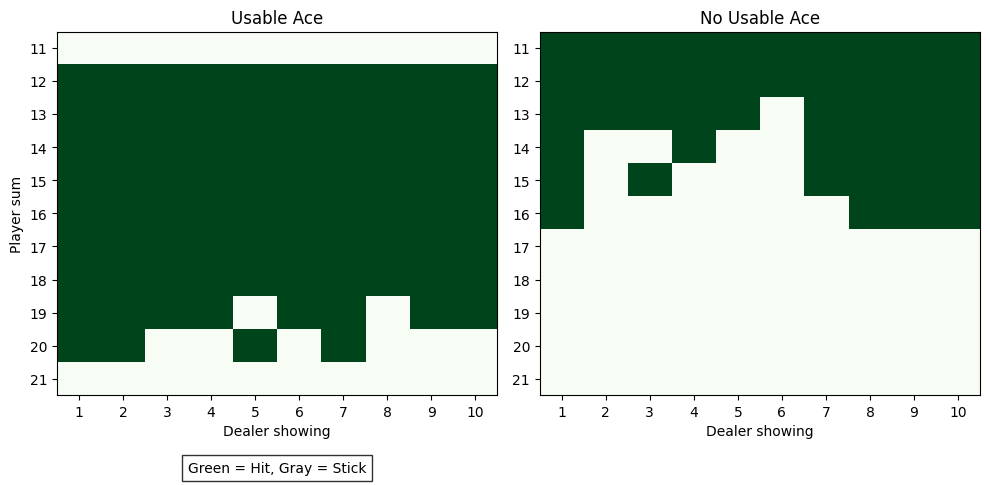

--------------------------------------------------------------

{'WINS': 37.998000000000005, 'NATURAL WINS': 0.0, 'LOSSES': 48.41, 'DRAWS': 13.591999999999999, 'TOTAL REWARD': -4238.0}


In [156]:
print('\nSARSA')

for num in episodes:
  y, Q_sarsa, policy = SARSA(env, episodes=num, learning_rate=0.05, discount=0.1, epsilon=1.0, epsilon_decay=0.99)
  total_results_sarsa = simulate_games_sarsa(env, policy)
  print('--------------------------------------------------------------')
  print('\nFOR SARSA WITH', num, 'EPISODES \nRESULTS ARE:', total_results_sarsa, '\nAND POLICY IS:')
  plot_policy(Q_sarsa)
  print('--------------------------------------------------------------\n')
  averages_sarsa.append(total_results_sarsa)


AV_S = {}


for key in averages_sarsa[0]:
    AV_S[key] = sum(d[key] for d in averages_sarsa) / len(averages_sarsa)

print(AV_S)


For the number of episodes, the more the better as long as we have time and conevrgence hasnt already been completed. Therefore, by doing millions of episodes we can see that the results get slightly better. Here the decision has to be: if increasing the number of episodes still leaves room for imporvement and the results keep getting better, there is no doubt trying with more episodes makes sense. Here It is proven that there is change eventhough it can be small. It allows for convergence to spread out and get better results over time.
Nevertheless, at some point the number of episodes makes the process extremly lenghty and the results do not improve that much or do not change at all, so by adding more and more episodes it is not going to magically make it better. If the algorithm converges and it is well programed, at some point it improves and imporves stops getting better

### 4.3. Influence of the Discount Factor

Conduct a study by varying the *discount factor* in each of the algorithms.

<u>Questions</u> (**1 point**):
- Run the algorithms with *discount factor* = 0.1, 0.5, 0.9 and the rest of the parameters the same as in previous exercises.
- Describe the changes in the optimal policy, comparing the result obtained with the result of previous exercises (*discount factor* = 1).


MONTE CARLO
Episode    65700/  100000 - Average reward -0.07

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


Episode    99900/  100000 - Average reward -0.07USING DISCOUNT FACTOR 0.1 WITH MONTE CARLO RESULTS ARE:
 {'WINS': 38.771, 'NATURAL WINS': 4.715, 'LOSSES': 47.85, 'DRAWS': 13.379, 'TOTAL REWARD': -2873.5}


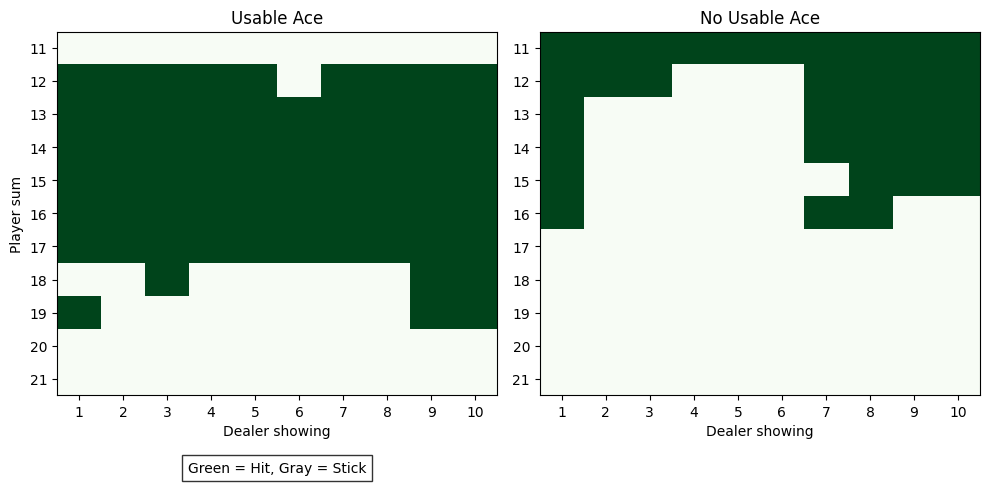

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.07USING DISCOUNT FACTOR 0.5 WITH MONTE CARLO RESULTS ARE:
 {'WINS': 38.391999999999996, 'NATURAL WINS': 4.741, 'LOSSES': 48.461999999999996, 'DRAWS': 13.145999999999999, 'TOTAL REWARD': -3831.5}


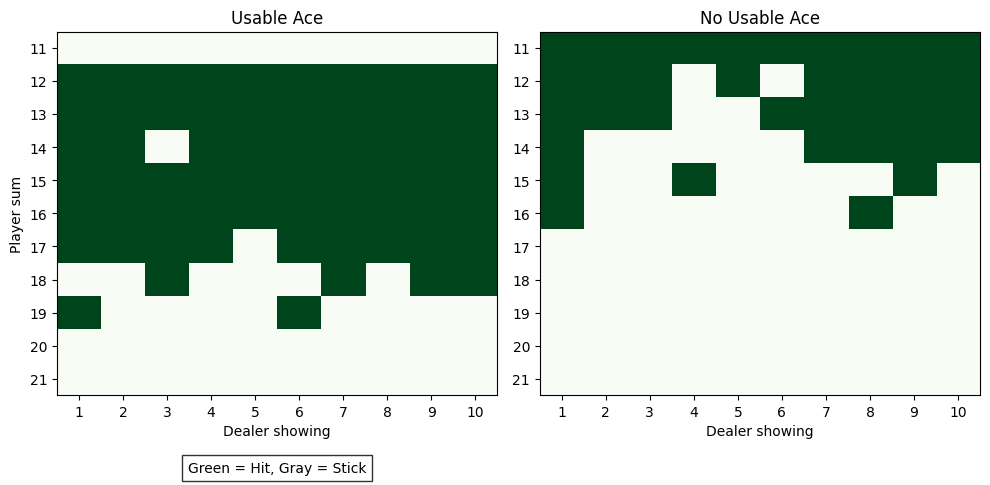

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.08USING DISCOUNT FACTOR 0.9 WITH MONTE CARLO RESULTS ARE:
 {'WINS': 38.83, 'NATURAL WINS': 4.609, 'LOSSES': 48.528, 'DRAWS': 12.642000000000001, 'TOTAL REWARD': -3645.5}


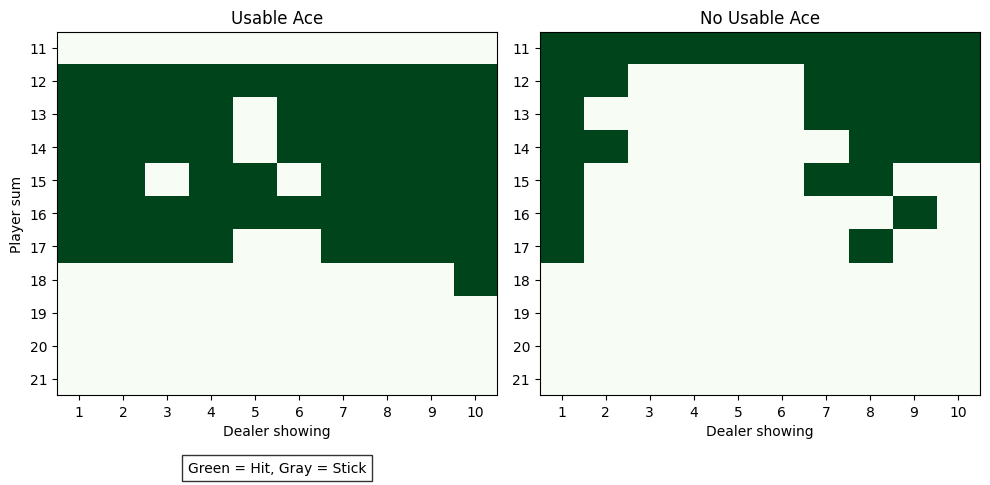

-------------------------------------------------------------------------------------

{'WINS': 38.66433333333333, 'NATURAL WINS': 4.6883333333333335, 'LOSSES': 48.28, 'DRAWS': 13.055666666666667, 'TOTAL REWARD': -3450.1666666666665}


In [148]:
#For the Naive Policy.
episodes =[0.1, 0.5, 0.9]
averages_naive = []
averages_mc = []
averages_sarsa = []

print('\nMONTE CARLO')

for discount in episodes:
  policy_mc, Q_mc = mc_control_onpolicy_epsilon_greedy(env, num_episodes=100000, gamma=discount, epsilon=1.0, epsilon_decay = 0.99) #call function to generate the policy and Q.
  total_results_mc = simulate_games_mc(env, policy_mc) #simulate for n episodes and check results.
  averages_mc.append(total_results_mc)
  print('USING DISCOUNT FACTOR', discount, 'WITH MONTE CARLO RESULTS ARE:\n', total_results_mc)
  plot_policy(Q_mc)
  print('-------------------------------------------------------------------------------------\n')


AV_MC = {}


for key in averages_mc[0]:
    AV_MC[key] = sum(d[key] for d in averages_mc) / len(averages_mc)

print(AV_MC)




SARSA
Episode    99900/  100000 - Average reward -0.04
USING DISCOUNT FACTOR 0.9 WITH SARSA RESULTS ARE:
 {'WINS': 38.327, 'NATURAL WINS': 0.0, 'LOSSES': 48.55, 'DRAWS': 13.123000000000001, 'TOTAL REWARD': -4109.0}


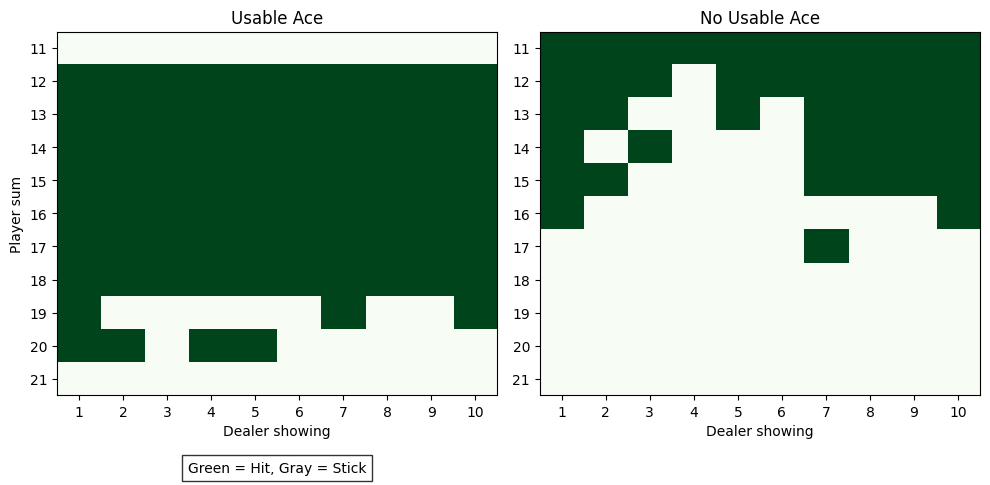

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.05
USING DISCOUNT FACTOR 0.9 WITH SARSA RESULTS ARE:
 {'WINS': 37.946999999999996, 'NATURAL WINS': 0.0, 'LOSSES': 48.272999999999996, 'DRAWS': 13.780000000000001, 'TOTAL REWARD': -4131.0}


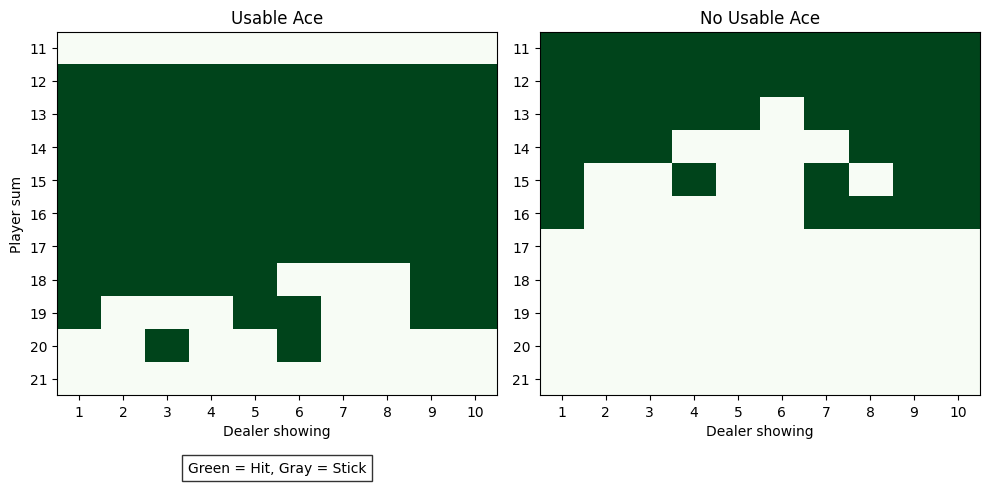

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.05
USING DISCOUNT FACTOR 0.9 WITH SARSA RESULTS ARE:
 {'WINS': 38.061, 'NATURAL WINS': 0.0, 'LOSSES': 47.972, 'DRAWS': 13.966999999999999, 'TOTAL REWARD': -3701.0}


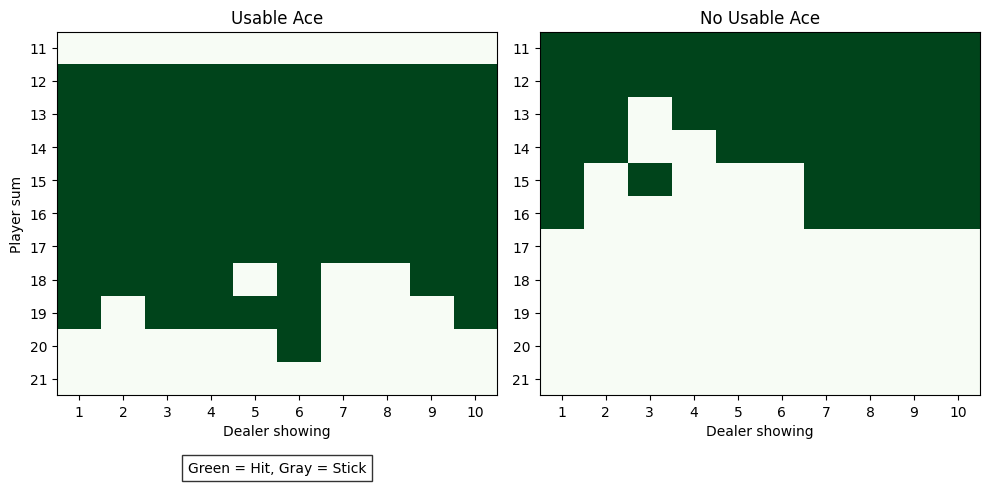

-------------------------------------------------------------------------------------

{'WINS': 38.11166666666667, 'NATURAL WINS': 0.0, 'LOSSES': 48.26499999999999, 'DRAWS': 13.623333333333335, 'TOTAL REWARD': -3980.3333333333335}


In [149]:
print('\nSARSA')

for d in episodes:
  y, Q_sarsa, policy = SARSA(env, episodes=100000, learning_rate=0.05, discount=d, epsilon=1.0, epsilon_decay=0.99)
  total_results_sarsa = simulate_games_sarsa(env, policy)
  averages_sarsa.append(total_results_sarsa)
  print('\nUSING DISCOUNT FACTOR', discount, 'WITH SARSA RESULTS ARE:\n', total_results_sarsa)
  plot_policy(Q_sarsa)
  print('-------------------------------------------------------------------------------------\n')


AV_S = {}


for key in averages_sarsa[0]:
    AV_S[key] = sum(d[key] for d in averages_sarsa) / len(averages_sarsa)

print(AV_S)


As we can see, the values for the average reward are better with smaller or larger values depending on the algorithm we are using. For Monte Carlo the smaller the value the better the final reward. Whilst for SARSA the reward gets better as we have a higher value for the discount factor. Policies are fairly similar, but the better the reward for each algorithm, the closer its produced policy is to the optimal one.

### 4.4. Influence of the Learning Rate

Conduct a study by varying the learning rate in the *SARSA* algorithm.

<u>Questions</u> (**1 point**):
- Run the *SARSA* algorithm with the following *learning rate* values: 0.001, 0.01, 0.1, and 0.9.
- Analyze the differences with the results obtained previously in terms of the number of errors relative to the optimal policy and the accumulated reward for every 100,000 episodes played.

In [150]:
lr = [0.001, 0.01, 0.1, 0.9]


SARSA
Episode    99900/  100000 - Average reward -0.07USING LEARNING RATE 0.001 WITH SARSA RESULTS ARE:
 {'WINS': 37.787, 'NATURAL WINS': 0.0, 'LOSSES': 49.212, 'DRAWS': 13.001, 'TOTAL REWARD': -5068.0}


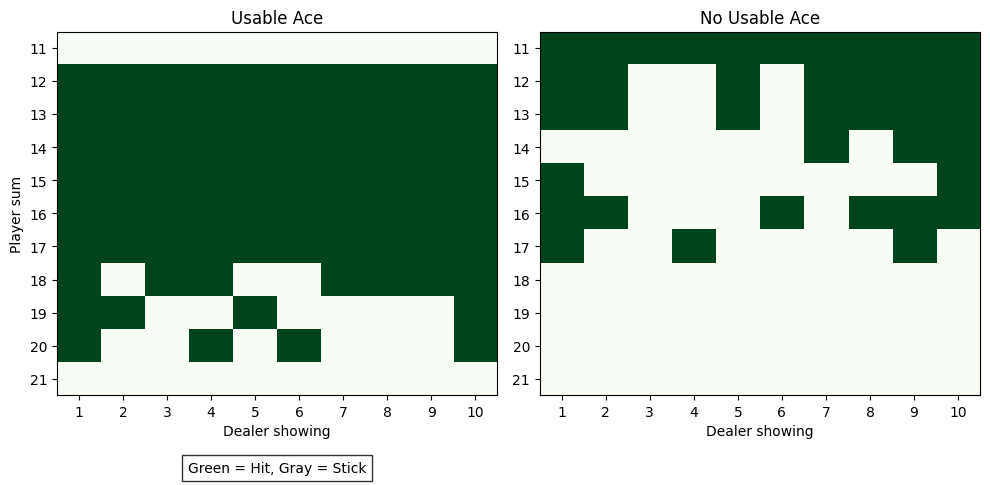

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.04USING LEARNING RATE 0.01 WITH SARSA RESULTS ARE:
 {'WINS': 38.806000000000004, 'NATURAL WINS': 0.0, 'LOSSES': 47.991, 'DRAWS': 13.203000000000001, 'TOTAL REWARD': -2783.0}


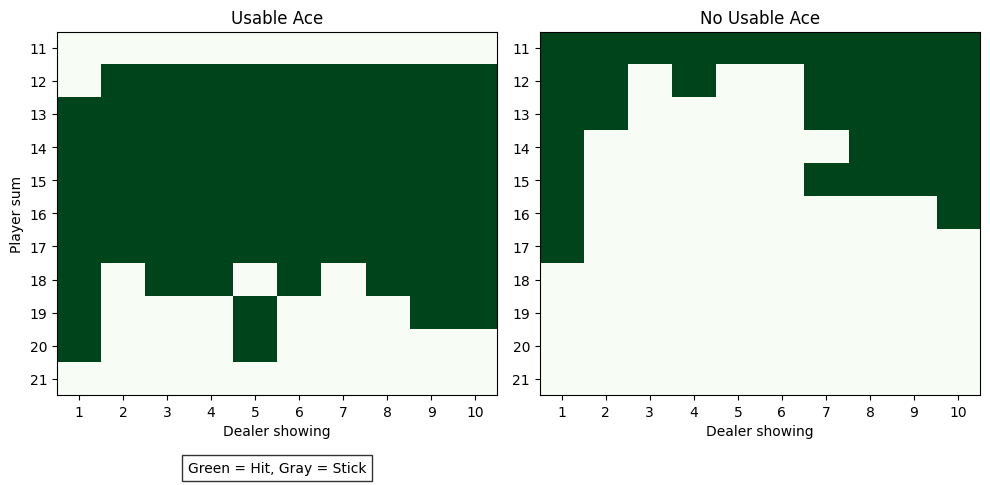

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.05USING LEARNING RATE 0.1 WITH SARSA RESULTS ARE:
 {'WINS': 36.848, 'NATURAL WINS': 0.0, 'LOSSES': 49.585, 'DRAWS': 13.567000000000002, 'TOTAL REWARD': -6453.5}


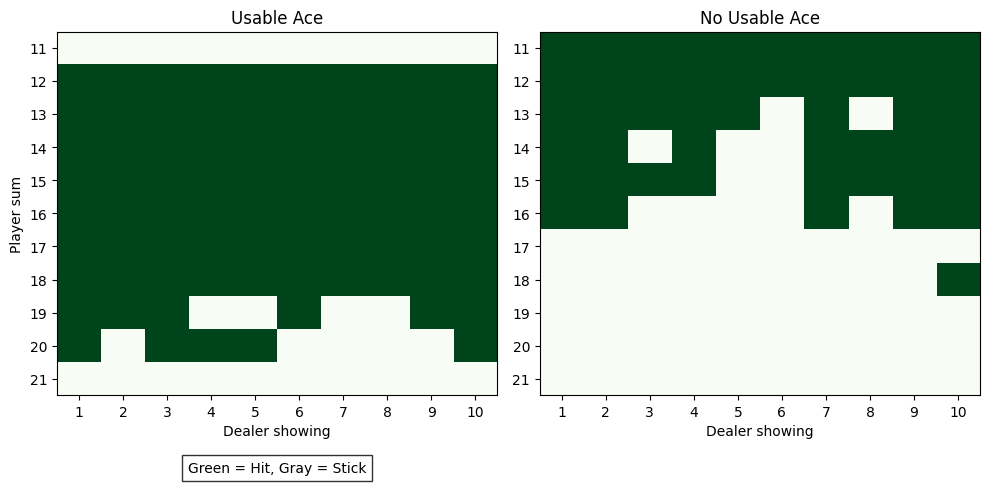

-------------------------------------------------------------------------------------

Episode    99900/  100000 - Average reward -0.07USING LEARNING RATE 0.9 WITH SARSA RESULTS ARE:
 {'WINS': 36.852000000000004, 'NATURAL WINS': 0.0, 'LOSSES': 49.74, 'DRAWS': 13.408000000000001, 'TOTAL REWARD': -6765.0}


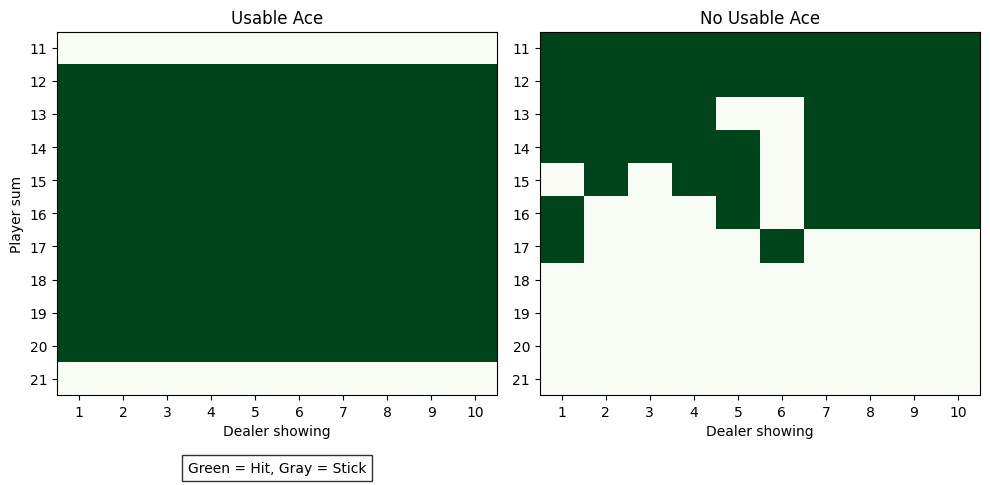

-------------------------------------------------------------------------------------

{'WINS': 37.815, 'NATURAL WINS': 0.0, 'LOSSES': 48.881375, 'DRAWS': 13.303625000000002, 'TOTAL REWARD': -4834.4375}


In [154]:
print('\nSARSA')

for l in lr:
  y, Q_sarsa, policy = SARSA(env, episodes=100000, learning_rate=l, discount=0.1, epsilon=1.0, epsilon_decay=0.99)
  total_results_sarsa = simulate_games_sarsa(env, policy)
  averages_sarsa.append(total_results_sarsa)
  print('USING LEARNING RATE', l, 'WITH SARSA RESULTS ARE:\n', total_results_sarsa)
  plot_policy(Q_sarsa)
  print('-------------------------------------------------------------------------------------\n')


AV_S = {}


for key in averages_sarsa[0]:
    AV_S[key] = sum(d[key] for d in averages_sarsa) / len(averages_sarsa)

print(AV_S)

As we can see, the best value for the lr is 0.01, so the usage of the learning rate in the algorithm before, where I thought 0.05 was the best option, was wrong. The better choice is 0.01 since it returns the best value for the reward and also the policy most similar to the optimal. With 0.001 the value is too small and the results are off. Then as the learning rate gets larger, the steps are too big so convergence happens before at a suboptimal and worse point that by using that value.

In [ ]:
from google.colab import files
!jupyter nbconvert --to html PRA1_BlackJack.ipynb
files.download('PRA1_BLACKJACK_PEREMAYOL.html')